In [67]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import statsmodels.api as sm

!pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba import plotDecisionTree, regressionSummary
from dmba.metric import AIC_score

# **1. Data Preprocessing:**

*   Read the data and remove any special characters and spaces from the variable names.
*   Convert the following four variables into categories and create dummy fariables. These include Category (18 categories), Currency (USD, GBP, Euro), EndDay (Monday–Sunday), and
Duration (1, 3, 5, 7, or 10 days).
*   Split the data using test_size=0.4






In [68]:
auctions = pd.read_csv("eBayAuctions.csv")
auctions.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [69]:
auctions.columns = [s.strip().replace(' ', '_') for s in auctions.columns]
auctions.columns = [s.replace('?', '') for s in auctions.columns]
auctions.columns = [s.capitalize() for s in auctions.columns]
auctions.columns

Index(['Category', 'Currency', 'Sellerrating', 'Duration', 'Endday',
       'Closeprice', 'Openprice', 'Competitive'],
      dtype='object')

In [70]:
auctions.Category = auctions.Category.astype('category')
auctions.Currency = auctions.Currency.astype('category')
auctions.Endday = auctions.Endday.astype('category')
auctions.Duration = auctions.Duration.astype('category')

auctions = pd.get_dummies(auctions, drop_first=True)

In [75]:
excluded_columns = ('Competitive', 'Closeprice')
outcome = 'Competitive'
predictors = [s for s in auctions.columns if s not in excluded_columns]

X = auctions[predictors]
y = auctions[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((1183, 31), (789, 31), (1183,), (789,))

# 2. Random Forest Model


Create a random forest using 500 estimators

Calculate the accuracy for both the training and validation data

In [86]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [87]:
print('Training Data')
classificationSummary(train_y, rf.predict(train_X))

print('\nValidation Data')
classificationSummary(valid_y, rf.predict(valid_X))

Training Data
Confusion Matrix (Accuracy 0.9239)

       Prediction
Actual   0   1
     0 511  42
     1  48 582

Validation Data
Confusion Matrix (Accuracy 0.7402)

       Prediction
Actual   0   1
     0 261  92
     1 113 323


In [84]:
# Extra - feature importance
importance = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns,
                   'importance': importance,
                   'std': std})
print(df.sort_values('importance', ascending=False))

                          feature  importance       std
1                       Openprice    0.324446  0.048314
0                    Sellerrating    0.243468  0.035275
25                     Endday_Mon    0.033313  0.015521
14      Category_Music/Movie/Game    0.024516  0.010150
23                     Duration_7    0.022960  0.011532
27                     Endday_Sun    0.022556  0.009334
20                    Currency_US    0.021750  0.009845
22                     Duration_5    0.021443  0.013200
7           Category_Collectibles    0.020819  0.007870
18          Category_Toys/Hobbies    0.019044  0.008465
26                     Endday_Sat    0.018229  0.007951
11         Category_Health/Beauty    0.017338  0.011564
3                  Category_Books    0.016982  0.007492
2             Category_Automotive    0.016911  0.008774
29                     Endday_Tue    0.015568  0.006948
24                    Duration_10    0.015006  0.008034
5   Category_Clothing/Accessories    0.014733  0

# 3. Neural Networks

*   Create a neural network using one hidden layer with two nodes.
*   Calculate the accuracy for both the training and validation data (Hint: use a confusion matrix)

In [88]:
nn = MLPClassifier(hidden_layer_sizes=2, activation='logistic', solver='lbfgs', random_state=1, max_iter=1000)
nn.fit(train_X, train_y)

MLPClassifier(activation='logistic', hidden_layer_sizes=2, max_iter=1000,
              random_state=1, solver='lbfgs')

In [90]:
print('Training Data')
classificationSummary(train_y, nn.predict(train_X))
print('\nValidation Data')
classificationSummary(valid_y, nn.predict(valid_X))

Training Data
Confusion Matrix (Accuracy 0.6771)

       Prediction
Actual   0   1
     0 464  89
     1 293 337

Validation Data
Confusion Matrix (Accuracy 0.6565)

       Prediction
Actual   0   1
     0 295  58
     1 213 223


# 4. Logistic Regression

*   Create a logistic regression.  Use C=1e42
*   What are the coefficients of the independent variables?
*   Interpret the impact of OpenPrice on the target variable
*   Calculate the accuracy of the model for both training and validation data

In [91]:
logit_reg = LogisticRegression(solver='liblinear', C=1e42, random_state=1)
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, random_state=1, solver='liblinear')

In [93]:
print('intercept ', logit_reg.intercept_[0]) 
print(pd.DataFrame({'coeff': logit_reg.coef_[0], 'odds': np.e**logit_reg.coef_[0]},
                   index=X.columns).sort_values(by='coeff', ascending=False))

intercept  0.42012222620366974
                                  coeff      odds
Category_Photography           2.035421  7.655477
Category_Business/Industrial   1.544728  4.686697
Currency_GBP                   1.529604  4.616346
Category_SportingGoods         1.007646  2.739145
Category_Electronics           0.778425  2.178040
Endday_Mon                     0.667544  1.949443
Duration_5                     0.354375  1.425290
Category_Computer              0.320001  1.377129
Category_Home/Garden           0.152849  1.165149
Currency_US                    0.071349  1.073955
Category_Toys/Hobbies          0.048896  1.050111
Category_Collectibles          0.040727  1.041568
Sellerrating                  -0.000047  0.999953
Openprice                     -0.004473  0.995537
Endday_Tue                    -0.086510  0.917127
Duration_10                   -0.120219  0.886726
Duration_3                    -0.155144  0.856292
Duration_7                    -0.164614  0.848221
Category_Books     

Interpretation: OpenPrice is 0.45% less likely to impact on the competitive auctions. 

In [94]:
print('Training Data')
classificationSummary(train_y, logit_reg.predict(train_X))
print('\nValidation Data')
classificationSummary(valid_y, logit_reg.predict(valid_X))

Training Data
Confusion Matrix (Accuracy 0.6729)

       Prediction
Actual   0   1
     0 352 201
     1 186 444

Validation Data
Confusion Matrix (Accuracy 0.6375)

       Prediction
Actual   0   1
     0 210 143
     1 143 293


# 5. Discriminant Analysis

*   Complete a discriminant analysis on the data
*   Calculate the accuracy of the model on both the training and validation data

In [96]:
lda = LinearDiscriminantAnalysis()
lda.fit(train_X, train_y)

LinearDiscriminantAnalysis()

In [97]:
print('Training Data')
classificationSummary(train_y, lda.predict(train_X))
print('\nValidation Data')
classificationSummary(valid_y, lda.predict(valid_X))

Training Data
Confusion Matrix (Accuracy 0.6729)

       Prediction
Actual   0   1
     0 357 196
     1 191 439

Validation Data
Confusion Matrix (Accuracy 0.6299)

       Prediction
Actual   0   1
     0 213 140
     1 152 284


# 6. Lift Charts

*   Create a lift chart for each model created using the validation data (submit code for each model)

In [127]:
# Lift chart for Random Forest
rf_pred = rf.predict(valid_X)
rf_prob = rf.predict_proba(valid_X)

rf_result = pd.DataFrame({'actual': valid_y,
                          'p_0': [p[0] for p in rf_prob],
                          'p_1': [p[1] for p in rf_prob],
                          'predicted': rf_pred})

df1 = rf_result.sort_values(by=['p_1'], ascending=False)
df1

,actual,p_0,p_1,predicted
1496,1,0.000,1.000,1
698,1,0.000,1.000,1
1501,1,0.000,1.000,1
1597,1,0.000,1.000,1
1406,1,0.000,1.000,1
...,...,...,...,...
1874,0,0.998,0.002,0
1636,1,0.998,0.002,0
1357,1,0.998,0.002,0
936,0,1.000,0.000,0


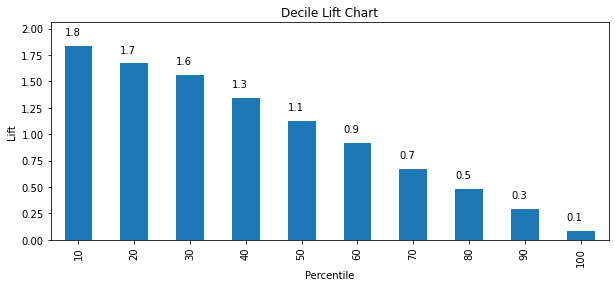

In [128]:
fig, axes = plt.subplots(figsize=(10, 4))
liftChart(df1['p_1'])

In [129]:
# Lift chart for Neural Networks
nn_pred = nn.predict(valid_X)
nn_prob = nn.predict_proba(valid_X)

nn_result = pd.DataFrame({'actual': valid_y,
                          'p_0': [p[0] for p in nn_prob],
                          'p_1': [p[1] for p in nn_prob],
                          'predicted': nn_pred})

df2 = nn_result.sort_values(by=['p_1'], ascending=False)
df2

,actual,p_0,p_1,predicted
285,1,0.105376,0.894624,1
142,1,0.105376,0.894624,1
258,1,0.105597,0.894403,1
158,1,0.105597,0.894403,1
159,1,0.105597,0.894403,1
...,...,...,...,...
1800,0,0.625618,0.374382,0
1780,0,0.625618,0.374382,0
680,0,0.625618,0.374382,0
1659,0,0.625618,0.374382,0


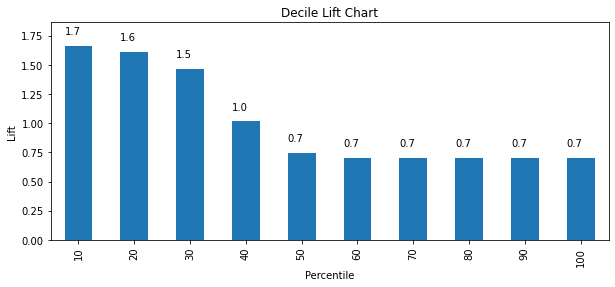

In [130]:
fig, axes = plt.subplots(figsize=(10, 4))
liftChart(df2['p_1'])

In [131]:
# Lift chart for Logistic Regression
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_prob = logit_reg.predict_proba(valid_X)

logit_result = pd.DataFrame({'actual': valid_y,
                             'p_0': [p[0] for p in logit_reg_prob],
                             'p_1': [p[1] for p in logit_reg_prob],
                             'predicted': logit_reg_pred})

df3 = logit_result.sort_values(by=['p_1'], ascending=False)
df3

,actual,p_0,p_1,predicted
1772,0,0.032678,0.967322,1
852,1,0.089455,0.910545,1
1428,1,0.097079,0.902921,1
955,1,0.098150,0.901850,1
1622,1,0.100665,0.899335,1
...,...,...,...,...
1081,1,0.911318,0.088682,0
348,0,0.911336,0.088664,0
1237,1,0.911678,0.088322,0
1955,0,0.941531,0.058469,0


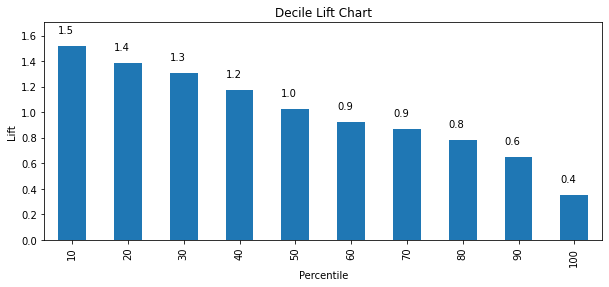

In [132]:
fig, axes = plt.subplots(figsize=(10, 4))
liftChart(df3['p_1'])

In [133]:
# Lift chart for Discriminant Analysis
lda_pred = lda.predict(valid_X)
lda_prob = lda.predict_proba(valid_X)

lda_result = pd.DataFrame({'actual': valid_y,
                           'p_0': [p[0] for p in lda_prob],
                           'p_1': [p[1] for p in lda_prob],
                           'predicted': lda_pred})

df4 = lda_result.sort_values(by=['p_1'], ascending=False)
df4

,actual,p_0,p_1,predicted
1772,0,0.030621,0.969379,1
852,1,0.090582,0.909418,1
1428,1,0.097290,0.902710,1
1622,1,0.098094,0.901906,1
955,1,0.098187,0.901813,1
...,...,...,...,...
935,0,0.898238,0.101762,0
1081,1,0.898474,0.101526,0
1237,1,0.898709,0.101291,0
1955,0,0.910753,0.089247,0


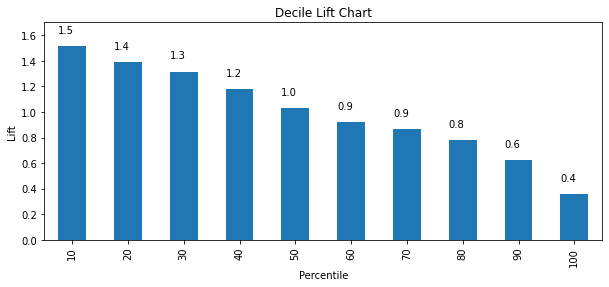

In [134]:
fig, axes = plt.subplots(figsize=(10, 4))
liftChart(df4['p_1'])

# 7. Model Evaluation

*   Which model is the best and why?

Below is the accuracy of the validation data from each model based on the Confusion Matrix:

Random Forest: 0.7402

Neural Networks: 0.6565

Logistic Regression: 0.6375

Discriminant Analysis: 0.6299

Random Forest has the highest accuracy among all models. However, the large discrepancy between the performance of its training and validation data indicates that there might be an overfitting in this model.

By considering the danger of overfitting, the best model will be Neural Networks, which has the next highest accuracy.